<a href="https://colab.research.google.com/github/stevejobws/Colaboratory/blob/master/gcn_pridiction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch
!pip install torchtext
!pip install torchvision
!pip install torch_sparse -i https://pypi.tuna.tsinghua.edu.cn/simple
!pip install torch_scatter -i https://pypi.tuna.tsinghua.edu.cn/simple
!pip install torch_geometric # 下载安装pytorch_geometric
!pip install networkx # 画图
import torch
import torch.nn.functional as F
import torch_geometric 
from torch_geometric.nn import GCNConv, ChebConv

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


RuntimeError: ignored

In [ ]:
! python -c "import torch_geometric; print(torch_geometric.__version__)" # 检查是否安装成功

Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/usr/local/lib/python3.6/dist-packages/torch_geometric/__init__.py", line 2, in <module>
    import torch_geometric.nn
  File "/usr/local/lib/python3.6/dist-packages/torch_geometric/nn/__init__.py", line 2, in <module>
    from .data_parallel import DataParallel
  File "/usr/local/lib/python3.6/dist-packages/torch_geometric/nn/data_parallel.py", line 5, in <module>
    from torch_geometric.data import Batch
  File "/usr/local/lib/python3.6/dist-packages/torch_geometric/data/__init__.py", line 1, in <module>
    from .data import Data
  File "/usr/local/lib/python3.6/dist-packages/torch_geometric/data/data.py", line 7, in <module>
    from torch_sparse import coalesce, SparseTensor
  File "/usr/local/lib/python3.6/dist-packages/torch_sparse/__init__.py", line 34, in <module>
    from .storage import SparseStorage  # noqa
  File "/usr/local/lib/python3.6/dist-packages/torch_sparse/storage.py", line 5, in <m

In [ ]:
! uname -a  # 查看系统  
! python --version  # 查看python版本 
! python -c 'import torch; print(torch.version.cuda)' # 查看cuda的版本，检查是否和cuda的一致
! nvcc --version # 查看nvcc版本 

Linux e4e606ebf6e4 4.19.112+ #1 SMP Thu Jul 23 08:00:38 PDT 2020 x86_64 x86_64 x86_64 GNU/Linux
Python 3.6.9
10.1
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243


In [ ]:
print(torch.version.cuda) # torch的cuda版本

10.1


In [8]:
# 导入数据
import pandas as pd

Adj = pd.read_csv('/content/drive/My Drive/Colab Notebooks/GCN_Prediction link/data/drug-diseaseNum.csv')
node_features = pd.read_csv('/content/drive/My Drive/Colab Notebooks/GCN_Prediction link/data/AllNodeAttribute.csv')
node_label = pd.read_csv('/content/drive/My Drive/Colab Notebooks/GCN_Prediction link/data/AllNode_label.csv')

In [31]:
Adj

,0,267
0,0,268
1,0,269
2,0,270
3,0,271
4,0,272
...,...,...
17408,266,660
17409,266,403
17410,266,404
17411,266,663


In [32]:
node_features

,0,0.7706328,0.010733238,0.5827176,-0.06261978,-0.23856387,-0.715823,1.0229808,0.18164602,-0.26039103,-0.5420329,0.23313928,-0.28343192,0.11714408,0.5314488,-0.06122111,-0.22952928,-0.7105971,0.28848463,0.09841086,0.18965468,-0.5119621,-0.2632837,0.0783294,0.19871941,1.0868483999999998,-0.2568045,0.026245711,0.09389911,-0.14249657,0.01881871,-0.23493719,-0.15342341,0.42577162,0.6739689,0.025524665,-0.2948406,-0.31587312,0.55261844,0.43735474,-0.08744249,0.5361331,-0.36645055,0.6569897,0.802005,-0.016102083,-0.66942054,0.8565628000000001,-0.101191685,-0.16558306,-0.40551326,-0.41094795,-0.027974876,-0.39776492,-0.509387,0.28056657,0.20877618,-0.099218085,-0.22935389,0.23234765,-1.0350324,1.2091292,0.36844373,0.41435245,-1.0654348
0,1,2.882159,1.241338,2.232549,-1.932836,-0.574318,0.168684,2.937954,1.398610,-0.260359,-1.253366,-0.997117,-1.355796,0.847303,2.447680,-0.573743,0.211870,-0.960837,1.536916,2.928266,-0.955619,-1.152885,0.548847,0.525967,-0.445511,2.999283,0.190644,-0.916012,0.877579,1.501392,-2.191907,-0.344929,-0.643345,1.808293,0.922850,0.823318,0.399970,0.415868,0.005898,-2.257816,-0.475472,0.610879,-1.345582,1.256365,0.962199,-1.093309,-1.647974,1.594285,0.584256,-1.293162,-1.844852,-0.580833,2.215265,-1.795820,-2.811482,0.229828,0.073673,0.256524,-0.438187,-0.097229,-0.740352,1.529813,-0.640376,1.717616,-1.703426
1,2,0.688133,-0.318813,0.999343,-0.651598,-0.407260,-0.314173,0.781863,0.242623,-0.107326,-0.972608,-0.235344,-0.511505,-0.138459,0.775548,-0.218838,0.545011,-0.670150,0.699975,0.817735,-0.134486,0.054736,0.374199,0.183914,-0.104466,1.410521,-0.258784,0.201976,0.270087,0.458823,-0.055942,0.035193,0.027436,1.150917,0.318230,0.150467,0.657710,-0.184495,-0.571191,-0.604887,-0.231566,0.001112,-0.379828,0.181649,0.533105,-0.220025,-0.499370,0.676739,-0.635464,-0.520307,-0.607030,0.455186,0.421789,-0.637401,-1.185999,-0.661417,0.244160,0.266237,-0.213120,0.249394,-0.382235,0.886608,-0.040592,0.387883,-0.961931
2,3,1.721908,0.388303,0.947409,-0.787672,-0.362458,-0.536777,1.290188,0.130461,-0.550028,-0.882603,-0.284483,0.195723,0.287096,0.741486,-0.613376,0.241035,-1.183460,0.651605,1.076140,0.284106,-1.281615,-0.727382,0.383454,-0.202577,1.619946,0.001538,-0.379740,0.251197,0.567685,-0.998128,-0.046036,-0.882844,0.740021,0.870464,0.363524,-0.268316,0.146103,0.422400,0.236998,-0.150375,0.789005,-1.078728,0.767913,1.031454,-1.020215,-0.265524,1.290493,-0.687332,-0.580685,-0.275520,0.351817,0.330816,-0.828862,-1.068953,-0.534331,-0.844828,0.119608,0.585099,0.437665,-1.466863,1.006176,-0.079589,0.593564,-1.152426
3,4,0.650453,-0.146959,0.802256,-0.280101,-0.731831,-0.456279,0.775432,-0.465780,0.143515,-0.736436,0.108304,-0.252066,0.123692,0.359086,-0.440906,-0.286168,-0.400844,0.719755,0.256401,0.432786,-0.412044,-0.066332,-0.045897,-0.033026,0.904498,0.185858,-0.173960,-0.415105,-0.231409,0.234141,0.299792,-0.222521,0.539466,0.284991,0.444050,0.151308,-0.550617,0.110464,-0.113436,-0.128214,-0.150840,-0.427944,0.444110,0.421779,-0.314363,-0.818235,0.472876,-0.264762,0.096127,-0.077573,0.012599,-0.271649,-0.296263,-0.772448,-0.508725,-0.160995,0.444162,0.061997,-0.419543,-0.450393,0.573340,-0.265548,0.279305,-0.208944
4,5,0.109805,-0.189683,0.301222,0.189257,0.174485,-0.396088,0.268056,0.363967,-0.306494,-0.857515,-0.064044,-0.278492,0.366741,0.323727,-0.041202,-0.457527,-0.592256,0.058035,0.381119,0.333784,-0.362219,-0.243467,0.141437,-0.012475,0.771640,0.328352,0.333306,0.156913,-0.125118,0.432134,-0.109195,0.065296,0.371117,0.092156,0.183601,-0.000676,-0.002262,0.320204,-0.055558,-0.053546,-0.182191,0.104103,0.101422,0.806096,0.072904,-0.428988,0.693647,-0.312175,-0.171792,-0.153653,-0.176002,0.244299,-0.264175,-0.228033,0.227927,0.060284,0.086738,-0.333917,0.296612,-0.501233,0.995152,0.179497,0.314474,-0.486160
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

In [33]:
node_label

,0,5
0,1,3
1,2,3
2,3,1
3,4,6
4,5,4
...,...,...
831,832,3
832,833,4
833,834,5
834,835,5


In [ ]:
import numpy as np
import scipy.sparse as sp
import torch

'''
先将所有由字符串表示的标签数组用set保存，set的重要特征就是元素没有重复，
因此表示成set后可以直接得到所有标签的总数，随后为每个标签分配一个编号，创建一个单位矩阵，
单位矩阵的每一行对应一个one-hot向量，也就是np.identity(len(classes))[i, :]，
再将每个数据对应的标签表示成的one-hot向量，类型为numpy数组
'''
def encode_onehot(labels):
    classes = set(labels)  # set() 函数创建一个无序不重复元素集
    classes_dict = {c: np.identity(len(classes))[i, :] for i, c in  # identity创建方矩阵
                    enumerate(classes)}     # 字典 key为label的值，value为矩阵的每一行
    # enumerate函数用于将一个可遍历的数据对象组合为一个索引序列
    labels_onehot = np.array(list(map(classes_dict.get, labels)),  # get函数得到字典key对应的value
                             dtype=np.int32)
    return labels_onehot
    # map() 会根据提供的函数对指定序列做映射
    # 第一个参数 function 以参数序列中的每一个元素调用 function 函数，返回包含每次 function 函数返回值的新列表
    #  map(lambda x: x ** 2, [1, 2, 3, 4, 5])
    #  output:[1, 4, 9, 16, 25]


def load_data(path="./data/cora/", dataset="cora"):
    """Load citation network dataset (cora only for now)"""
    print('Loading {} dataset...'.format(dataset))

    idx_features_labels = np.genfromtxt("{}{}.content".format(path, dataset),
                                        dtype=np.dtype(str))
    features = sp.csr_matrix(idx_features_labels[:, 1:-1], dtype=np.float32)  # 储存为csr型稀疏矩阵
    labels = encode_onehot(idx_features_labels[:, -1])
    # content file的每一行的格式为 ： <paper_id> <word_attributes>+ <class_label>
    #    分别对应 0, 1:-1, -1
    # feature为第二列到倒数第二列，labels为最后一列

    # build graph
    # cites file的每一行格式为：  <cited paper ID>  <citing paper ID>
    # 根据前面的contents与这里的cites创建图，算出edges矩阵与adj 矩阵
    idx = np.array(idx_features_labels[:, 0], dtype=np.int32)
    idx_map = {j: i for i, j in enumerate(idx)}
    # 由于文件中节点并非是按顺序排列的，因此建立一个编号为0-(node_size-1)的哈希表idx_map，
    # 哈希表中每一项为id: number，即节点id对应的编号为number
    edges_unordered = np.genfromtxt("{}{}.cites".format(path, dataset),
                                    dtype=np.int32)
    # edges_unordered为直接从边表文件中直接读取的结果，是一个(edge_num, 2)的数组，每一行表示一条边两个端点的idx
    edges = np.array(list(map(idx_map.get, edges_unordered.flatten())),  # flatten：降维，返回一维数组
                     dtype=np.int32).reshape(edges_unordered.shape)
    # 边的edges_unordered中存储的是端点id，要将每一项的id换成编号。
    # 在idx_map中以idx作为键查找得到对应节点的编号，reshape成与edges_unordered形状一样的数组
    adj = sp.coo_matrix((np.ones(edges.shape[0]), (edges[:, 0], edges[:, 1])),  # coo型稀疏矩阵
                        shape=(labels.shape[0], labels.shape[0]),
                        dtype=np.float32)
    # 根据coo矩阵性质，这一段的作用就是，网络有多少条边，邻接矩阵就有多少个1，
    # 所以先创建一个长度为edge_num的全1数组，每个1的填充位置就是一条边中两个端点的编号，
    # 即edges[:, 0], edges[:, 1]，矩阵的形状为(node_size, node_size)。


    # build symmetric adjacency matrix   论文里A^=(D~)^0.5 A~ (D~)^0.5这个公式
    adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj)
    # 对于无向图，邻接矩阵是对称的。上一步得到的adj是按有向图构建的，转换成无向图的邻接矩阵需要扩充成对称矩阵
    features = normalize(features)
    adj = normalize(adj + sp.eye(adj.shape[0]))   # eye创建单位矩阵，第一个参数为行数，第二个为列数
    # 对应公式A~=A+IN

    # 分别构建训练集、验证集、测试集，并创建特征矩阵、标签向量和邻接矩阵的tensor，用来做模型的输入
    idx_train = range(140)
    idx_val = range(200, 500)
    idx_test = range(500, 1500)

    features = torch.FloatTensor(np.array(features.todense()))  # tensor为pytorch常用的数据结构
    labels = torch.LongTensor(np.where(labels)[1])
    adj = sparse_mx_to_torch_sparse_tensor(adj)   # 邻接矩阵转为tensor处理

    idx_train = torch.LongTensor(idx_train)
    idx_val = torch.LongTensor(idx_val)
    idx_test = torch.LongTensor(idx_test)

    return adj, features, labels, idx_train, idx_val, idx_test

def normalize(mx):
    """Row-normalize sparse matrix"""
    rowsum = np.array(mx.sum(1))  # 对每一行求和
    r_inv = np.power(rowsum, -1).flatten()  # 求倒数
    r_inv[np.isinf(r_inv)] = 0.  # 如果某一行全为0，则r_inv算出来会等于无穷大，将这些行的r_inv置为0
    r_mat_inv = sp.diags(r_inv)  # 构建对角元素为r_inv的对角矩阵
    mx = r_mat_inv.dot(mx)
    # 用对角矩阵与原始矩阵的点积起到标准化的作用，原始矩阵中每一行元素都会与对应的r_inv相乘，最终相当于除以了sum
    return mx

def accuracy(output, labels):
    preds = output.max(1)[1].type_as(labels) # 使用type_as(tesnor)将张量转换为给定类型的张量。
    correct = preds.eq(labels).double()  # 记录等于preds的label eq:equal
    correct = correct.sum()
    return correct / len(labels)


def sparse_mx_to_torch_sparse_tensor(sparse_mx):    # 把一个sparse matrix转为torch稀疏张量
    """
    numpy中的ndarray转化成pytorch中的tensor : torch.from_numpy()
    pytorch中的tensor转化成numpy中的ndarray : numpy()
    """
    sparse_mx = sparse_mx.tocoo().astype(np.float32)
    indices = torch.from_numpy(np.vstack((sparse_mx.row, sparse_mx.col)).astype(np.int64))
    # 不懂的可以去看看COO性稀疏矩阵的结构
    values = torch.from_numpy(sparse_mx.data)
    shape = torch.Size(sparse_mx.shape)
    return torch.sparse.FloatTensor(indices, values, shape)


预处理数据集的格式，转化为GCN所需要的格式

In [3]:
import pandas as pd
import numpy as np
# import file is  attribute of node
node_features = pd.read_csv('/content/drive/My Drive/Colab Notebooks/GCN_Prediction link/data/AllNodeAttribute.csv',header = None) 
num = node_features.shape[0] # Number of nodes
node_features  


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64
0,0,0.770633,0.010733,0.582718,-0.062620,-0.238564,-0.715823,1.022981,0.181646,-0.260391,-0.542033,0.233139,-0.283432,0.117144,0.531449,-0.061221,-0.229529,-0.710597,0.288485,0.098411,0.189655,-0.511962,-0.263284,0.078329,0.198719,1.086848,-0.256804,0.026246,0.093899,-0.142497,0.018819,-0.234937,-0.153423,0.425772,0.673969,0.025525,-0.294841,-0.315873,0.552618,0.437355,-0.087442,0.536133,-0.366451,0.656990,0.802005,-0.016102,-0.669421,0.856563,-0.101192,-0.165583,-0.405513,-0.410948,-0.027975,-0.397765,-0.509387,0.280567,0.208776,-0.099218,-0.229354,0.232348,-1.035032,1.209129,0.368444,0.414352,-1.065435
1,1,2.882159,1.241338,2.232549,-1.932836,-0.574318,0.168684,2.937954,1.398610,-0.260359,-1.253366,-0.997117,-1.355796,0.847303,2.447680,-0.573743,0.211870,-0.960837,1.536916,2.928266,-0.955619,-1.152885,0.548847,0.525967,-0.445511,2.999283,0.190644,-0.916012,0.877579,1.501392,-2.191907,-0.344929,-0.643345,1.808293,0.922850,0.823318,0.399970,0.415868,0.005898,-2.257816,-0.475472,0.610879,-1.345582,1.256365,0.962199,-1.093309,-1.647974,1.594285,0.584256,-1.293162,-1.844852,-0.580833,2.215265,-1.795820,-2.811482,0.229828,0.073673,0.256524,-0.438187,-0.097229,-0.740352,1.529813,-0.640376,1.717616,-1.703426
2,2,0.688133,-0.318813,0.999343,-0.651598,-0.407260,-0.314173,0.781863,0.242623,-0.107326,-0.972608,-0.235344,-0.511505,-0.138459,0.775548,-0.218838,0.545011,-0.670150,0.699975,0.817735,-0.134486,0.054736,0.374199,0.183914,-0.104466,1.410521,-0.258784,0.201976,0.270087,0.458823,-0.055942,0.035193,0.027436,1.150917,0.318230,0.150467,0.657710,-0.184495,-0.571191,-0.604887,-0.231566,0.001112,-0.379828,0.181649,0.533105,-0.220025,-0.499370,0.676739,-0.635464,-0.520307,-0.607030,0.455186,0.421789,-0.637401,-1.185999,-0.661417,0.244160,0.266237,-0.213120,0.249394,-0.382235,0.886608,-0.040592,0.387883,-0.961931
3,3,1.721908,0.388303,0.947409,-0.787672,-0.362458,-0.536777,1.290188,0.130461,-0.550028,-0.882603,-0.284483,0.195723,0.287096,0.741486,-0.613376,0.241035,-1.183460,0.651605,1.076140,0.284106,-1.281615,-0.727382,0.383454,-0.202577,1.619946,0.001538,-0.379740,0.251197,0.567685,-0.998128,-0.046036,-0.882844,0.740021,0.870464,0.363524,-0.268316,0.146103,0.422400,0.236998,-0.150375,0.789005,-1.078728,0.767913,1.031454,-1.020215,-0.265524,1.290493,-0.687332,-0.580685,-0.275520,0.351817,0.330816,-0.828862,-1.068953,-0.534331,-0.844828,0.119608,0.585099,0.437665,-1.466863,1.006176,-0.079589,0.593564,-1.152426
4,4,0.650453,-0.146959,0.802256,-0.280101,-0.731831,-0.456279,0.775432,-0.465780,0.143515,-0.736436,0.108304,-0.252066,0.123692,0.359086,-0.440906,-0.286168,-0.400844,0.719755,0.256401,0.432786,-0.412044,-0.066332,-0.045897,-0.033026,0.904498,0.185858,-0.173960,-0.415105,-0.231409,0.234141,0.299792,-0.222521,0.539466,0.284991,0.444050,0.151308,-0.550617,0.110464,-0.113436,-0.128214,-0.150840,-0.427944,0.444110,0.421779,-0.314363,-0.818235,0.472876,-0.264762,0.096127,-0.077573,0.012599,-0.271649,-0.296263,-0.772448,-0.508725,-0.160995,0.444162,0.061997,-0.419543,-0.450393,0.573340,-0.265548,0.279305,-0.208944
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
832,832,0.092474,0.106150,0.033633,0.018442,0.365770,0.026157,0.192186,-0.005236,-0.217018,0.257617,0.053886,0.152891,-0.122927,0.130594,-0.034565,-0.123680,-0.024969,0.082651,-0.083302,-0.207902,-0.276132,0.104665,-0.138261,0.175597,0.038199,-0.013455,-0.133683,-0.142527,-0.042970,-0.077926,-0.069572,0.217869,-0.284175,0.278465,-0.007701,0.073461,-0.324276,-0.116313,0.068643,-0.304055,0.147916,-0.450253,0.243640,0.015325,0.139896,0.207937,-0.348907,-0.123072,0.070664,0.271669,0.138426

In [4]:
# 将词向量提取为特征,第二列到倒数第一列
features =node_features.iloc[:,1:]
 # 检查特征：共64个特征，837个样本点
print(features.shape)

(837, 64)


In [5]:
# 提取节点标签
node_label = pd.read_csv('/content/drive/My Drive/Colab Notebooks/GCN_Prediction link/data/AllNode_label.csv',header = None)
labels = node_label[1] # 提取节点标签列
labels.head()


0    5
1    3
2    3
3    1
4    6
Name: 1, dtype: int64

In [17]:
np.where(labels)[0]

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [16]:
!pip install networkx # 画图
# 提取关系对
node_relationship = pd.read_csv('/content/drive/My Drive/Colab Notebooks/GCN_Prediction link/data/drug-diseaseNum.csv',header = None)

# # 创建一个规模和邻接矩阵一样大小的矩阵
# matrix = np.zeros((num,num))
# # 创建邻接矩阵
# for i ,j in zip(node_relationship[0],node_relationship[1]):
#     x = map[i] ; y = map[j]  # 替换论文编号为[0,2707]
#     matrix[x][y] = matrix[y][x] = 1 #有引用关系的样本点之间取1
# # 查看邻接矩阵的元素和（按每列汇总）
# print(sum(matrix))


TypeError: ignored

In [ ]:
!pip install networkx # 画图

In [6]:
node_relationship = pd.read_csv('/content/drive/My Drive/Colab Notebooks/GCN_Prediction link/data/drug-diseaseNum.csv',header = None)
node_relationship

,0,1
0,0,267
1,0,268
2,0,269
3,0,270
4,0,271
...,...,...
17409,266,660
17410,266,403
17411,266,404
17412,266,663


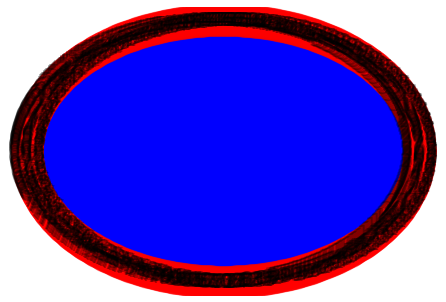

In [7]:

# 提取关系对
node_relationship = pd.read_csv('/content/drive/My Drive/Colab Notebooks/GCN_Prediction link/data/drug-diseaseNum.csv',header = None)
import networkx as nx
G = nx.Graph()
G.add_edges_from([edge for edge in zip(node_relationship[0],node_relationship[1])])

nx.draw(G,
        # pos = nx.random_layout(G),
        # pos = nx.spring_layout(G),
        # pos = nx.shell_layout(G),
        pos = nx.circular_layout(G),
        node_color = 'r',
        edge_color = 'b',
        with_labels = True,
        font_size =20,
        node_size =1000,
        alpha=0.3)

In [8]:
Adj = nx.adjacency_matrix(G)
Adj.todense()

matrix([[0, 1, 1, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [11]:
Adj

<837x837 sparse matrix of type '<class 'numpy.longlong'>'
	with 34828 stored elements in Compressed Sparse Row format>

In [23]:
type(node_features)

pandas.core.frame.DataFrame

In [9]:
import scipy.sparse as sp
def load_data(adj,node_features,node_labels):

    features = sp.csr_matrix(node_features, dtype=np.float32)  # 储存为csr型稀疏矩阵
    # build symmetric adjacency matrix   论文里A^=(D~)^0.5 A~ (D~)^0.5这个公式
    adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj)
    # 对于无向图，邻接矩阵是对称的。上一步得到的adj是按有向图构建的，转换成无向图的邻接矩阵需要扩充成对称矩阵
    features = normalize(features)
    adj = normalize(adj + sp.eye(adj.shape[0]))   # eye创建单位矩阵，第一个参数为行数，第二个为列数
    # 对应公式A~=A+IN
    # 分别构建训练集、验证集、测试集，并创建特征矩阵、标签向量和邻接矩阵的tensor，用来做模型的输入
    idx_train = range(500)
    idx_val = range(500, 660)
    idx_test = range(660, 836)  

    features = torch.FloatTensor(np.array(features.todense()))  # tensor为pytorch常用的数据结构
    labels = torch.LongTensor(np.where(node_labels)[0])
    adj = sparse_mx_to_torch_sparse_tensor(adj)   # 邻接矩阵转为tensor处理

    idx_train = torch.LongTensor(idx_train)
    idx_val = torch.LongTensor(idx_val)
    idx_test = torch.LongTensor(idx_test)

    return adj, features, labels, idx_train, idx_val, idx_test  
def normalize(mx):
    """Row-normalize sparse matrix"""
    rowsum = np.array(mx.sum(1))  # 对每一行求和
    r_inv = np.power(rowsum, -1).flatten()  # 求倒数
    r_inv[np.isinf(r_inv)] = 0.  # 如果某一行全为0，则r_inv算出来会等于无穷大，将这些行的r_inv置为0
    r_mat_inv = sp.diags(r_inv)  # 构建对角元素为r_inv的对角矩阵
    mx = r_mat_inv.dot(mx)
    # 用对角矩阵与原始矩阵的点积起到标准化的作用，原始矩阵中每一行元素都会与对应的r_inv相乘，最终相当于除以了sum
    return mx

def accuracy(output, labels):
    preds = output.max(1)[1].type_as(labels) # 使用type_as(tesnor)将张量转换为给定类型的张量。
    correct = preds.eq(labels).double()  # 记录等于preds的label eq:equal
    correct = correct.sum()
    return correct / len(labels)


def sparse_mx_to_torch_sparse_tensor(sparse_mx):    # 把一个sparse matrix转为torch稀疏张量
    """
    numpy中的ndarray转化成pytorch中的tensor : torch.from_numpy()
    pytorch中的tensor转化成numpy中的ndarray : numpy()
    """
    sparse_mx = sparse_mx.tocoo().astype(np.float32)
    indices = torch.from_numpy(np.vstack((sparse_mx.row, sparse_mx.col)).astype(np.int64))
    # 不懂的可以去看看COO性稀疏矩阵的结构
    values = torch.from_numpy(sparse_mx.data)
    shape = torch.Size(sparse_mx.shape)
    return torch.sparse.FloatTensor(indices, values, shape)

In [10]:
import math

import torch

from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module


class GraphConvolution(Module):

    # 初始化层：输入feature，输出feature，权重，偏移
    def __init__(self, in_features, out_features, bias=True):
        super(GraphConvolution, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = Parameter(torch.FloatTensor(in_features, out_features))  # FloatTensor建立tensor
        # 常见用法self.v = torch.nn.Parameter(torch.FloatTensor(hidden_size))：
        # 首先可以把这个函数理解为类型转换函数，将一个不可训练的类型Tensor转换成可以训练的类型parameter并将这个parameter
        # 绑定到这个module里面，所以经过类型转换这个self.v变成了模型的一部分，成为了模型中根据训练可以改动的参数了。
        # 使用这个函数的目的也是想让某些变量在学习的过程中不断的修改其值以达到最优化。
        if bias:
            self.bias = Parameter(torch.FloatTensor(out_features))
        else:
            self.register_parameter('bias', None)
            # Parameters与register_parameter都会向parameters写入参数，但是后者可以支持字符串命名
        self.reset_parameters()

    # 初始化权重
    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        # size()函数主要是用来统计矩阵元素个数，或矩阵某一维上的元素个数的函数  size（1）为行
        self.weight.data.uniform_(-stdv, stdv)  # uniform() 方法将随机生成下一个实数，它在 [x, y] 范围内
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    '''
    前馈运算 即计算A~ X W(0)
    input X与权重W相乘，然后adj矩阵与他们的积稀疏乘
    直接输入与权重之间进行torch.mm操作，得到support，即XW
    support与adj进行torch.spmm操作，得到output，即AXW选择是否加bias
    '''
    def forward(self, input, adj):
        support = torch.mm(input, self.weight)
        # torch.mm(a, b)是矩阵a和b矩阵相乘，torch.mul(a, b)是矩阵a和b对应位相乘，a和b的维度必须相等
        output = torch.spmm(adj, support)
        if self.bias is not None:
            return output + self.bias
        else:
            return output

    def __repr__(self):
        return self.__class__.__name__ + ' (' \
               + str(self.in_features) + ' -> ' \
               + str(self.out_features) + ')'



In [11]:
import torch.nn as nn
import torch.nn.functional as F
class GCN(nn.Module):
    def __init__(self, nfeat, nhid, nclass, dropout):  # 底层节点的参数，feature的个数；隐层节点个数；最终的分类数
        super(GCN, self).__init__()  #  super()._init_()在利用父类里的对象构造函数

        self.gc1 = GraphConvolution(nfeat, nhid)   # gc1输入尺寸nfeat，输出尺寸nhid
        self.gc2 = GraphConvolution(nhid, nclass)  # gc2输入尺寸nhid，输出尺寸ncalss
        self.dropout = dropout

    # 输入分别是特征和邻接矩阵。最后输出为输出层做log_softmax变换的结果
    def forward(self, x, adj):
        x = F.relu(self.gc1(x, adj))    # adj即公式Z=softmax(A~Relu(A~XW(0))W(1))中的A~
        x = F.dropout(x, self.dropout, training=self.training)  # x要dropout
        x = self.gc2(x, adj)
        return F.log_softmax(x, dim=1)

In [10]:
features.shape[0]

837

In [12]:
from __future__ import division
from __future__ import print_function

import time
import argparse  # argparse 是python自带的命令行参数解析包，可以用来方便地读取命令行参数
import numpy as np

import torch
import torch.nn.functional as F
import torch.optim as optim



# Training settings
learning_rate = 0.01
weight_decay = 5e-4
epoch_num = 200
dropout = 0.5

#in_size = node_features  #设置输入层的维数
hi_size = 16 #设置隐藏层的维数
#out_size = node_label #设置输入层的维数


# Load data
adj, features, labels, idx_train, idx_val, idx_test = load_data(Adj,features,labels)

# Model and optimizer
model = GCN(nfeat=features.shape[1],
            nhid=hi_size,
            nclass=labels.max().item() + 1,
            dropout=dropout)
optimizer = optim.Adam(model.parameters(),lr=learning_rate, weight_decay=weight_decay)

# 数据写入cuda，便于后续加速

# if args.cuda:
#     model.cuda()   # . cuda()会分配到显存里（如果gpu可用）
#     features = features.cuda()
#     adj = adj.cuda()
#     labels = labels.cuda()
#     idx_train = idx_train.cuda()
#     idx_val = idx_val.cuda()
#     idx_test = idx_test.cuda()
#global node_vec

def train(epoch_num):
    t = time.time()  # 返回当前时间
    model.train()
    optimizer.zero_grad()
    # optimizer.zero_grad()意思是把梯度置零，也就是把loss关于weight的导数变成0.
    # pytorch中每一轮batch需要设置optimizer.zero_gra
    output = model(features, adj)
    loss_train = F.nll_loss(output[idx_train], labels[idx_train])
    # 由于在算output时已经使用了log_softmax，这里使用的损失函数就是NLLloss，如果前面没有加log运算，
    # 这里就要使用CrossEntropyLoss了
    # 损失函数NLLLoss() 的输入是一个对数概率向量和一个目标标签. 它不会为我们计算对数概率，
    # 适合最后一层是log_softmax()的网络. 损失函数 CrossEntropyLoss() 与 NLLLoss() 类似,
    # 唯一的不同是它为我们去做 softmax.可以理解为：CrossEntropyLoss()=log_softmax() + NLLLoss()
    # https://blog.csdn.net/hao5335156/article/details/80607732
    acc_train = accuracy(output[idx_train], labels[idx_train])  #计算准确率
    loss_train.backward()  # 反向求导  Back Propagation
    optimizer.step()  # 更新所有的参数  Gradient Descent

    #if not args.fastmode:
        # Evaluate validation set performance separately,
        # deactivates dropout during validation run.
    model.eval()  # eval() 函数用来执行一个字符串表达式，并返回表达式的值
    output = model(features, adj)
    node_vec = output
    #print(node_vec.shape)
    loss_val = F.nll_loss(output[idx_val], labels[idx_val])    # 验证集的损失函数
    acc_val = accuracy(output[idx_val], labels[idx_val])
    print('Epoch: {:04d}'.format(epoch+1),
          'loss_train: {:.4f}'.format(loss_train.item()),
          'acc_train: {:.4f}'.format(acc_train.item()),
          'loss_val: {:.4f}'.format(loss_val.item()),
          'acc_val: {:.4f}'.format(acc_val.item()),
          'time: {:.4f}s'.format(time.time() - t))

# 定义测试函数，相当于对已有的模型在测试集上运行对应的loss与accuracy
def test():
    model.eval()
    output = model(features, adj)
    loss_test = F.nll_loss(output[idx_test], labels[idx_test])
    acc_test = accuracy(output[idx_test], labels[idx_test])
    print("Test set results:",
          "loss= {:.4f}".format(loss_test.item()),
          "accuracy= {:.4f}".format(acc_test.item()))


# Train model  逐个epoch进行train，最后test
t_total = time.time()
for epoch in range(epoch_num):
    train(epoch)
print("Optimization Finished!")
print("Total time elapsed: {:.4f}s".format(time.time() - t_total))

test()


Epoch: 0001 loss_train: 6.7301 acc_train: 0.0000 loss_val: 6.7629 acc_val: 0.0000 time: 0.3127s
Epoch: 0002 loss_train: 6.7024 acc_train: 0.0020 loss_val: 6.8108 acc_val: 0.0000 time: 0.0373s
Epoch: 0003 loss_train: 6.6632 acc_train: 0.0060 loss_val: 6.8810 acc_val: 0.0000 time: 0.0382s
Epoch: 0004 loss_train: 6.6126 acc_train: 0.0020 loss_val: 6.9796 acc_val: 0.0000 time: 0.0377s
Epoch: 0005 loss_train: 6.5518 acc_train: 0.0020 loss_val: 7.1115 acc_val: 0.0000 time: 0.0392s
Epoch: 0006 loss_train: 6.4843 acc_train: 0.0020 loss_val: 7.2831 acc_val: 0.0000 time: 0.0464s
Epoch: 0007 loss_train: 6.4192 acc_train: 0.0020 loss_val: 7.4984 acc_val: 0.0000 time: 0.0407s
Epoch: 0008 loss_train: 6.3428 acc_train: 0.0020 loss_val: 7.7553 acc_val: 0.0000 time: 0.0401s
Epoch: 0009 loss_train: 6.2855 acc_train: 0.0020 loss_val: 8.0468 acc_val: 0.0000 time: 0.0374s
Epoch: 0010 loss_train: 6.2461 acc_train: 0.0040 loss_val: 8.3646 acc_val: 0.0000 time: 0.0395s
Epoch: 0011 loss_train: 6.2069 acc_train

In [13]:
output = model(features, adj)

In [14]:
output

tensor([[ -0.6518, -14.9067,  -5.9982,  ..., -14.4112, -14.4119, -14.4115],
        [-14.3754,  -4.1419,  -9.9019,  ..., -12.2404, -12.2414, -12.2426],
        [ -6.0218,  -9.4285,  -1.5601,  ..., -15.8995, -15.9006, -15.8991],
        ...,
        [ -6.0880, -22.9709, -17.1834,  ..., -17.3383, -17.3392, -17.3388],
        [ -5.1564, -21.1178, -14.3515,  ..., -15.1317, -15.1327, -15.1326],
        [ -6.6963, -22.1689, -17.6316,  ..., -15.8482, -15.8490, -15.8511]],
       grad_fn=<LogSoftmaxBackward>)

In [16]:
output.shape

torch.Size([837, 837])

In [32]:
output1 = output.detach().numpy()
np.savetxt("/content/drive/My Drive/Colab Notebooks/GCN_Prediction link/data/output.txt",output1) 

In [25]:
torch.save(output,'/content/drive/My Drive/Colab Notebooks/GCN_Prediction link/data/output.csv')

In [26]:
data_vec=torch.load('/content/drive/My Drive/Colab Notebooks/GCN_Prediction link/data/output.pt')
data_vec

tensor([[ -0.6518, -14.9067,  -5.9982,  ..., -14.4112, -14.4119, -14.4115],
        [-14.3754,  -4.1419,  -9.9019,  ..., -12.2404, -12.2414, -12.2426],
        [ -6.0218,  -9.4285,  -1.5601,  ..., -15.8995, -15.9006, -15.8991],
        ...,
        [ -6.0880, -22.9709, -17.1834,  ..., -17.3383, -17.3392, -17.3388],
        [ -5.1564, -21.1178, -14.3515,  ..., -15.1317, -15.1327, -15.1326],
        [ -6.6963, -22.1689, -17.6316,  ..., -15.8482, -15.8490, -15.8511]],
       requires_grad=True)

In [17]:
output[idx_test].shape

torch.Size([176, 837])

In [ ]:
import torch.optim as optim

learning_rate = le-2
weight_decay = 5e-4
epoch_num = 200

in_size = node_features  #设置输入层的维数
hi_size = 16 #设置隐藏层的维数
out_size = node_label #设置输入层的维数

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # 判断是否可以使用GPU来训练
# model = GCN().to(device)
# data = dataset[0].to(device) 
model = GCN(in_size, hi_size, out_size)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay) # 使用Adam来优化参数

model.train()
for epoch in range(epoch_num):
  optimizer.zero_grad()
  pred = model()
  loss = F.nll_loss(pred[data.train_mask], data.y[data.train_mask])
  print('epoch %s, loss %.3f'%(epoch, loss))
  loss.backward()
  optimizer.step()

model.eval()
_, pred = model(data.x, data.edge_index).max(dim=1)
correct = int(pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
acc = correct / int(data.test_mask.sum())
print('Accracy %.3f'%(acc))
